# Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Load Images

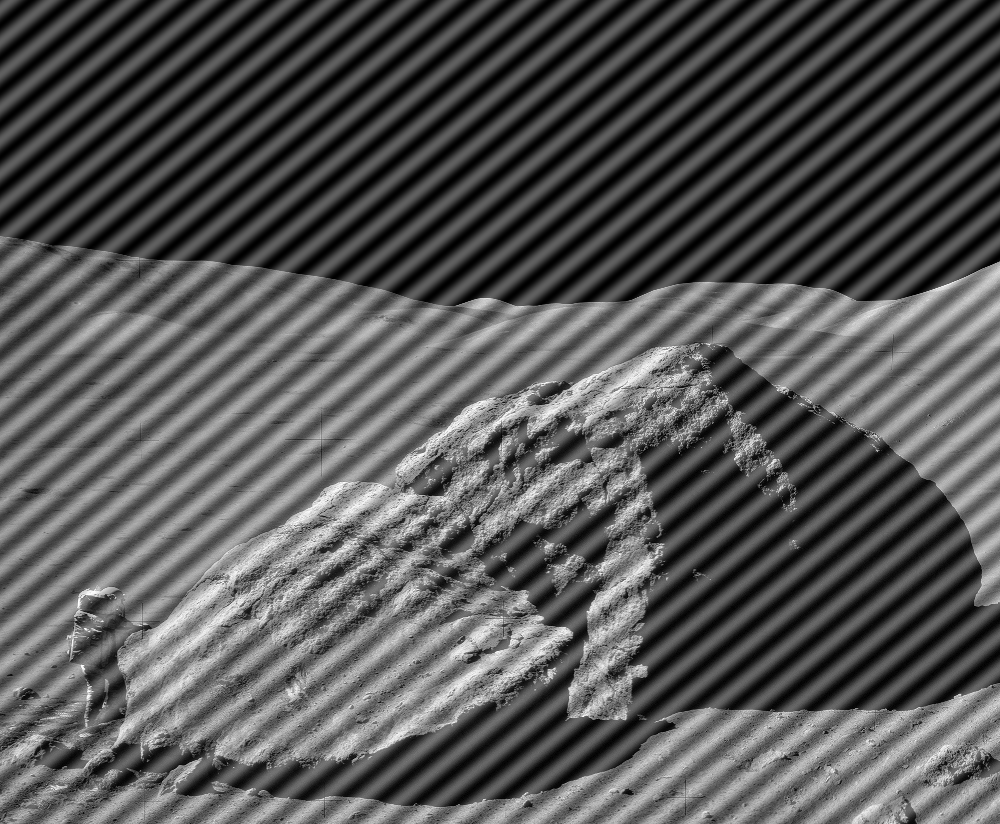

In [26]:
img1 = Image.open('astronaut-interference.tif').convert('L')
display(img1)

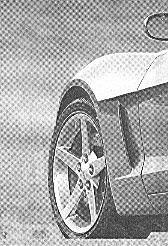

In [27]:
img2 = Image.open('car-moire-pattern.tif').convert('L')
display(img2)

# Useful Functions

In [38]:
def show_results(image, spectrum, masked_spectrum=None, filtered_image=None):
    plt.imshow(image, cmap='gray')
    plt.show()
    plt.imshow(spectrum, cmap='gray')
    plt.show()

def FT(image):
    # image to array
    image_array = np.array(image)
    
    # 2D FFT
    fft_array = np.fft.fft2(image_array)
    fshift = np.fft.fftshift(fft_array)
    
    # FFT image visable
    fft_img = 20 * np.log(1 + np.abs(fshift))
    
    return fft_img

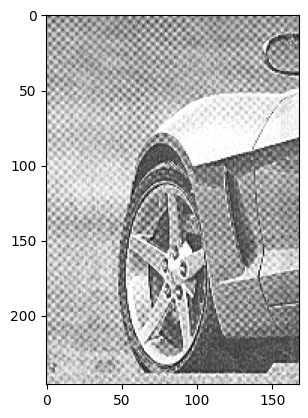

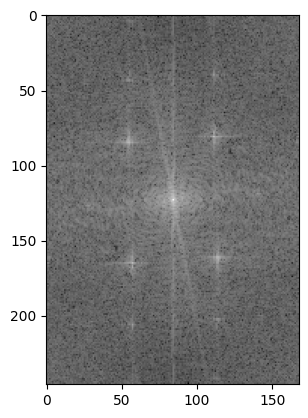

In [39]:
spectrum = FT(img2)
show_results(img2, spectrum)

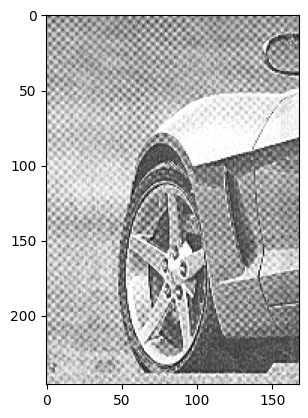

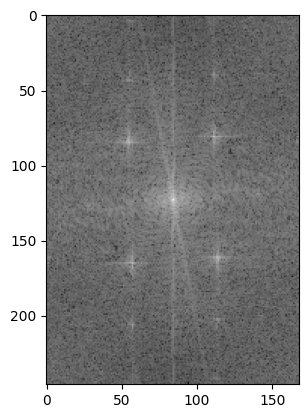

In [25]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 讀取圖片
img = np.array(img2)

# 將圖片轉換到頻率域
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)

# 計算頻率域的幅度
magnitude_spectrum = 20 * np.log(np.abs(fshift))

# 顯示原始圖片和頻率域的結果
plt.imshow(img, cmap='gray')
plt.show()

plt.imshow(magnitude_spectrum, cmap='gray')
plt.show()
